In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Define constants in a dictionary
config = {
    'file_path': "https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/main/SunPower_Full.csv",
    'target_variable': 'Active_Power',
    'predictors': ['temperature_2m', 'relativehumidity_2m', 'direct_radiation',
                   'diffuse_radiation', 'windspeed_10m', 'cloudcover', 'season'],
    'categorical_variables': ['season'],
    'standardize_predictor_list': ['temperature_2m', 'relativehumidity_2m',
                                    'direct_radiation', 'diffuse_radiation',
                                    'windspeed_10m', 'cloudcover']
}

# Load data
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df.rename(columns={'timestamp': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df[config['target_variable']] = df[config['target_variable']].clip(lower=0)  # Set negative values to 0
    return df

# Add season
def add_season(df):
    def season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'fall'
    df['season'] = df['date'].dt.month.apply(season)
    return df

# Choose only 7-18 interval
def choose_interval(df):
    df = df.sort_values('date')
    df = df.set_index('date')
    df = df.between_time('07:00', '18:00')
    return df

# Split data
def split_data(df):
    ord_enc = OrdinalEncoder()
    df['season'] = ord_enc.fit_transform(df[['season']])
    cutoff_date = df.index.min() + pd.DateOffset(years=7)
    train = df.loc[:cutoff_date]
    test = df.loc[cutoff_date + pd.DateOffset(hours=1):]
    return train, test

# Standardize data
def standardize_data(train, test):
    X_train = train[config['standardize_predictor_list']]
    X_test = test[config['standardize_predictor_list']]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = train[config['target_variable']]
    y_test = test[config['target_variable']]
    return X_train, X_test, y_train, y_test

# Train Random Forest Regressor
def train_rf_regressor(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    print("Evaluation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    return y_pred

# Main function
def main():
    # Load and preprocess data
    df = load_data(config['file_path'])
    df = add_season(df)
    df = choose_interval(df)
    train, test = split_data(df)
    X_train, X_test, y_train, y_test = standardize_data(train, test)

    # Train and evaluate Random Forest
    rf_model = train_rf_regressor(X_train, y_train)
    print("Best Parameters:", rf_model.best_params_)
    y_pred = evaluate_model(rf_model, X_test, y_test)

    # Optional: Save predictions
    test['Predicted_Power'] = y_pred
    print(test[['Predicted_Power', config['target_variable']]].head())

if __name__ == "__main__":
    main()


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Evaluation Metrics:
MAE: 0.32
RMSE: 0.55
R²: 0.88
                     Predicted_Power  Active_Power
date                                              
2020-07-22 08:00:00         0.743685      0.781067
2020-07-22 09:00:00         2.015606      2.222433
2020-07-22 10:00:00         3.269030      3.266800
2020-07-22 11:00:00         4.012569      3.996233
2020-07-22 12:00:00         4.352823      4.325633


<ipython-input-9-704d1dd2f299>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Power'] = y_pred


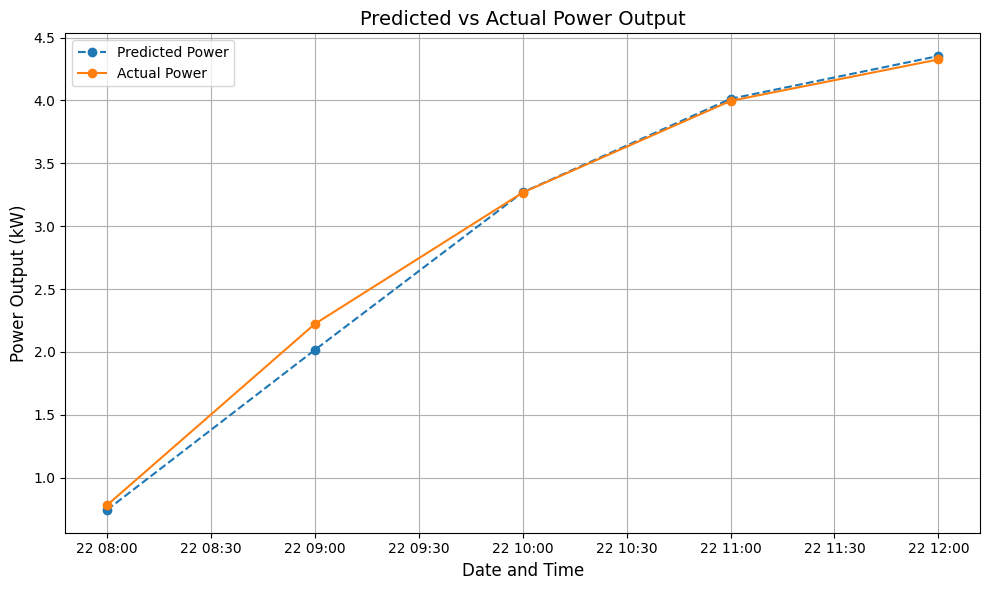

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data for Predicted vs Actual values
data = {
    "date": [
        "2020-07-22 08:00:00",
        "2020-07-22 09:00:00",
        "2020-07-22 10:00:00",
        "2020-07-22 11:00:00",
        "2020-07-22 12:00:00",
    ],
    "Predicted_Power": [0.743685, 2.015606, 3.269030, 4.012569, 4.352823],
    "Active_Power": [0.781067, 2.222433, 3.266800, 3.996233, 4.325633],
}

# Create a DataFrame
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["Predicted_Power"], label="Predicted Power", marker="o", linestyle="--")
plt.plot(df["date"], df["Active_Power"], label="Actual Power", marker="o", linestyle="-")

# Adding labels and title
plt.title("Predicted vs Actual Power Output", fontsize=14)
plt.xlabel("Date and Time", fontsize=12)
plt.ylabel("Power Output (kW)", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np
import pandas as pd

# Generate a sample dataset or load your dataset
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Model saved to random_forest_model.pkl")

# Load the model
loaded_model = joblib.load('random_forest_model.pkl')
print("Model loaded successfully")

# Make predictions
y_pred = loaded_model.predict(X_test)

# Evaluate the model
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    return mae, rmse, r2

# Call the evaluation function
evaluate_model(y_test, y_pred)


Model saved to random_forest_model.pkl
Model loaded successfully

Evaluation Metrics:
Mean Absolute Error (MAE): 40.18
Root Mean Squared Error (RMSE): 51.20
R² Score: 0.84


(40.177080494230346, 51.20344866411072, 0.8445988311470158)